In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Model
from PIL import Image
from sklearn.neural_network import MLPClassifier

# Set random seeds to ensure the reproducible results
from tensorflow.keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Data loading and preprocessing

In [ ]:
# dataset for training model
#data_dir = '/content/drive/My Drive/app/traindata/'
data_dir = '/content/drive/My Drive/app/traindata_with_extra_images/'

# the directory to store model
model_save_dir = '/content/drive/My Drive/app/'

# testdata directory
testdata_dir = '/content/drive/My Drive/app/testdata'

In [ ]:
# use data augmentation to create more instance to train and validate the model
# use split parameter to spilt the data into the training and validation
batch_size=32
# Our original images consist in RGB coefficients in the 0-255, but such values
# would be too high for our model to process (given a typical learning rate),
# so we target values between 0 and 1 instead by scaling with a 1/255.
train_datagen = ImageDataGenerator(validation_split=0.2,
                                 rescale=1./255,
                                 rotation_range=30,
                                 shear_range= 0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

# Normalize the test data images, resize them but don't augment them, to eliminate the
# uncertainty of testing results.
validation_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

# testdataset
testdata_gen = ImageDataGenerator(rescale=1./255)

# load the data from the training directory and set them to two flows training /validation
train = train_datagen.flow_from_directory(data_dir, target_size=(300,300), shuffle=True,
                                          classes=['cherry','strawberry','tomato'],
                                          batch_size=batch_size, subset='training')

test = validation_datagen.flow_from_directory(data_dir, target_size=(300,300), shuffle=True,
                                              batch_size=batch_size, subset='validation')

testdata = testdata_gen.flow_from_directory(testdata_dir, target_size=(300,300),
                                            batch_size=4)

Found 5818 images belonging to 3 classes.
Found 1453 images belonging to 3 classes.
Found 93 images belonging to 3 classes.


In [ ]:
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
checkPoint = ModelCheckpoint(filepath='/content/drive/My Drive/app/model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

EDA

In [ ]:
# List the classes and their encoded number
train.class_indices

{'cherry': 0, 'strawberry': 1, 'tomato': 2}

In [ ]:
# Provided dataset distribution after remove noise/irrelavent images
print('Training Data')
for direc in os.listdir('/content/drive/My Drive/app/traindata/'):
    print(direc, ':',len(os.listdir('/content/drive/My Drive/app/traindata/'+direc)))

Training Data
strawberry : 1474
tomato : 1424
cherry : 1461


In [ ]:
# Provided + downloadede dataset distribution after remove noise/irrelavent images
print('Training Data')
for direc in os.listdir('/content/drive/My Drive/app/traindata_with_extra_images/'):
    print(direc, ':',len(os.listdir('/content/drive/My Drive/app/traindata_with_extra_images/'+direc)))

Training Data
cherry : 2420
tomato : 2424
strawberry : 2427


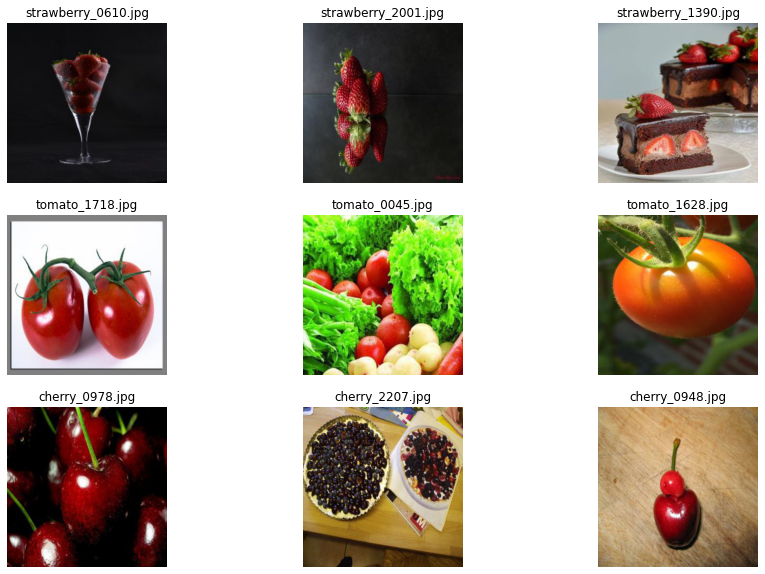

In [ ]:
# Display the data in the training set

fig, axs = plt.subplots(3, 3)
fig.set_size_inches(15,10, forward=True)

disp_images = []
row = 0
for direc in os.listdir(data_dir):
    img_path = os.listdir(data_dir + direc)
    for i in range(3):
        img = Image.open(data_dir + direc + '/' + img_path[i])
        axs[row, i].imshow(img)
        axs[row, i].set_title(img_path[i])
        axs[row, i].axis('off')
    row += 1
plt.show()

Functions of training, evaluating and saving the models

In [ ]:
# function of training the model
def train_model(model):
  #history = model.fit(train, validation_data = test, epochs = 50, verbose = 1)
  # adding callbacks to find the best model
  history = model.fit(train, validation_data = test, epochs = 100, verbose = 1, callbacks=[earlyStop,checkPoint])
  return history, model

In [ ]:
# function of evaluating the model
def evaluate_model(history_model):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(history_model.history['val_accuracy'], 'tab:orange', label='val_acc')
    ax1.plot(history_model.history['accuracy'], 'tab:blue', label='acc')
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylabel('Val_Accuracy')
    ax1.set_xlabel('Number of epoch')

    ax2.plot(history_model.history['val_loss'], 'tab:orange', label='val_loss')
    ax2.plot(history_model.history['loss'], 'tab:blue', label='loss')
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylabel('Val_Loss')
    ax2.set_xlabel('Number of epoch')
    return plt.show()

In [ ]:
# function of saving the model
def save_model(model,name):
    #Save the keras model for later evaluation
    path = model_save_dir + name + '.h5'
    model.save(path)
    print("Model Saved Successfully.")

Build MLP model

In [ ]:
def build_MLP_model():
    model = Sequential()
    # layer 1
    model.add(Flatten(input_shape = (300, 300, 3)))
    model.add(Dense(256, activation='relu'))
    # layer 2
    model.add(Dense(128, activation='relu'))
    # layer 3
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
MLP_model = build_MLP_model()
MLP_model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_23 (Flatten)         (None, 270000)            0         
_________________________________________________________________
dense_49 (Dense)             (None, 256)               69120256  
_________________________________________________________________
dense_50 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_51 (Dense)             (None, 3)                 387       
Total params: 69,153,539
Trainable params: 69,153,539
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train MLP model
history_MLP, MLP_model_save = train_model(MLP_model)

Epoch 1/50
108/108 [==============================] - 76s 698ms/step - loss: 20.2032 - accuracy: 0.3768 - val_loss: 7.5803 - val_accuracy: 0.3508
Epoch 2/50
108/108 [==============================] - 74s 687ms/step - loss: 6.1171 - accuracy: 0.4139 - val_loss: 5.8182 - val_accuracy: 0.3264
Epoch 3/50
108/108 [==============================] - 74s 682ms/step - loss: 4.6537 - accuracy: 0.4020 - val_loss: 2.3166 - val_accuracy: 0.4878
Epoch 4/50
108/108 [==============================] - 74s 681ms/step - loss: 2.4441 - accuracy: 0.4287 - val_loss: 2.3177 - val_accuracy: 0.3972
Epoch 5/50
108/108 [==============================] - 73s 678ms/step - loss: 1.8603 - accuracy: 0.4530 - val_loss: 1.2205 - val_accuracy: 0.4669
Epoch 6/50
108/108 [==============================] - 73s 680ms/step - loss: 1.3178 - accuracy: 0.4655 - val_loss: 1.2168 - val_accuracy: 0.4111
Epoch 7/50
108/108 [==============================] - 73s 677ms/step - loss: 1.2483 - accuracy: 0.4696 - val_loss: 1.1961 - val_a

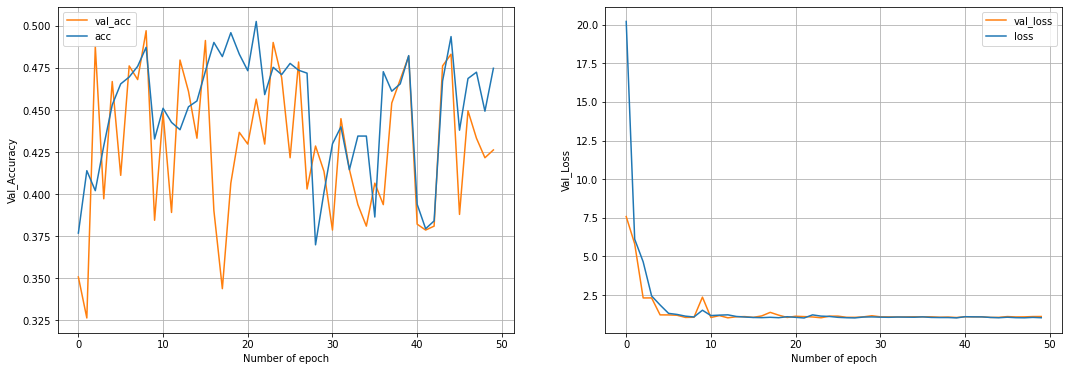

In [ ]:
# Evaluate MLP model
evaluate_model(history_MLP)

In [ ]:
save_model(MLP_model_save,'MLP_model')

Model Saved Successfully.


Build CNN model

In [ ]:

def build_basic_CNN_model():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu'))
     # layer 5
     model.add(Dense(3, activation='softmax'))
     
     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
     model.summary()
     epoch = model.fit(train, validation_data = test, epochs = 50, verbose = 1)
     return epoch, model

In [ ]:
# train the model
epoch, CNN_based_model = build_basic_CNN_model()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 156800)           

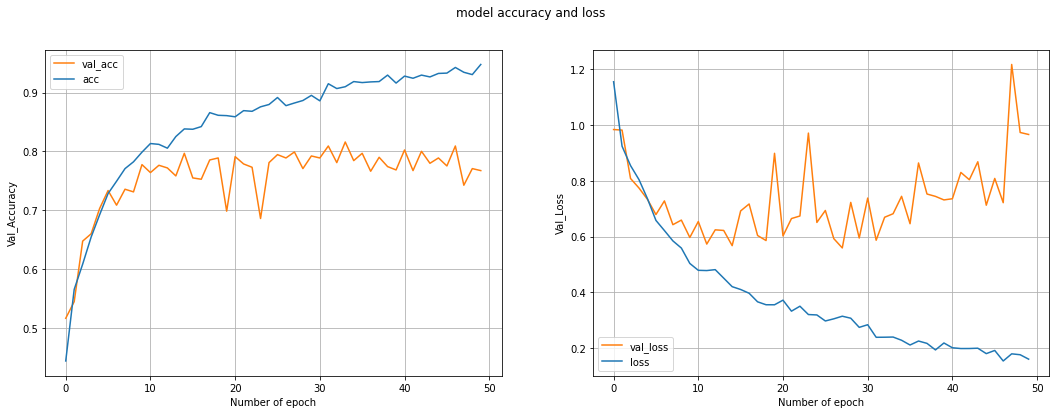

In [ ]:
# Evaluate basic CNN model
evaluate_model()


Optimize CNN model

In [ ]:
# apply dropout 0.25 to each layers except for last one
def build_tuned_CNN_model():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu'))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
model = build_tuned_CNN_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 71, 128)      

In [ ]:
history_CNN_tuned, CNN_tuned_model = train_model(model)

Epoch 1/50
71/71 [==============================] - 74s 1s/step - loss: 1.4192 - accuracy: 0.3687 - val_loss: 1.0666 - val_accuracy: 0.4120
Epoch 2/50
71/71 [==============================] - 72s 1s/step - loss: 1.0106 - accuracy: 0.4783 - val_loss: 1.0301 - val_accuracy: 0.4977
Epoch 3/50
71/71 [==============================] - 72s 1s/step - loss: 0.9542 - accuracy: 0.5400 - val_loss: 0.9821 - val_accuracy: 0.5181
Epoch 4/50
71/71 [==============================] - 71s 1s/step - loss: 0.9500 - accuracy: 0.5409 - val_loss: 0.9439 - val_accuracy: 0.5542
Epoch 5/50
71/71 [==============================] - 71s 1000ms/step - loss: 0.9197 - accuracy: 0.5750 - val_loss: 0.9136 - val_accuracy: 0.5971
Epoch 6/50
71/71 [==============================] - 72s 1s/step - loss: 0.8924 - accuracy: 0.5975 - val_loss: 0.9212 - val_accuracy: 0.6185
Epoch 7/50
71/71 [==============================] - 73s 1s/step - loss: 0.8753 - accuracy: 0.6017 - val_loss: 0.9225 - val_accuracy: 0.6005
Epoch 8/50
71/71

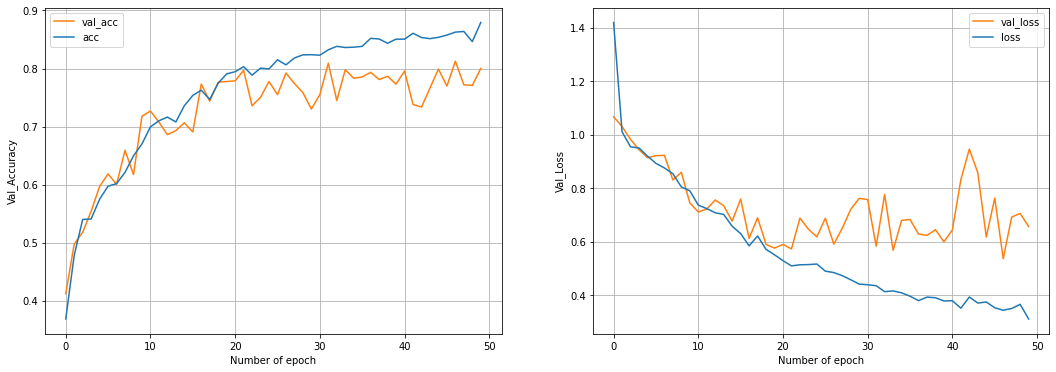

In [ ]:
# evaluate tuned CNN model
evaluate_model(history_CNN_tuned)

In [ ]:
#  apply regulizer L1 = 0.01 to the three layers with the highest parameters.
def build_tuned_CNN_model_1():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l1(0.01)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_1 = build_tuned_CNN_model_1()
CNN_model_1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 71, 71, 128)      

In [ ]:
history_CNN_tuned_1, CNN_tuned_model_1 = train_model(CNN_model_1)

Epoch 1/50
71/71 [==============================] - 75s 1s/step - loss: 50.1242 - accuracy: 0.3382 - val_loss: 15.9135 - val_accuracy: 0.3330
Epoch 2/50
71/71 [==============================] - 74s 1s/step - loss: 14.3560 - accuracy: 0.3143 - val_loss: 13.9079 - val_accuracy: 0.3330
Epoch 3/50
71/71 [==============================] - 74s 1s/step - loss: 13.7717 - accuracy: 0.3258 - val_loss: 13.4299 - val_accuracy: 0.3330
Epoch 4/50
71/71 [==============================] - 74s 1s/step - loss: 13.7207 - accuracy: 0.3233 - val_loss: 13.5032 - val_accuracy: 0.3330
Epoch 5/50
71/71 [==============================] - 73s 1s/step - loss: 13.7218 - accuracy: 0.3176 - val_loss: 13.8098 - val_accuracy: 0.3341
Epoch 6/50
71/71 [==============================] - 73s 1s/step - loss: 13.7239 - accuracy: 0.3272 - val_loss: 13.8241 - val_accuracy: 0.3341
Epoch 7/50
71/71 [==============================] - 73s 1s/step - loss: 13.7258 - accuracy: 0.3250 - val_loss: 13.6640 - val_accuracy: 0.3341
Epoch 

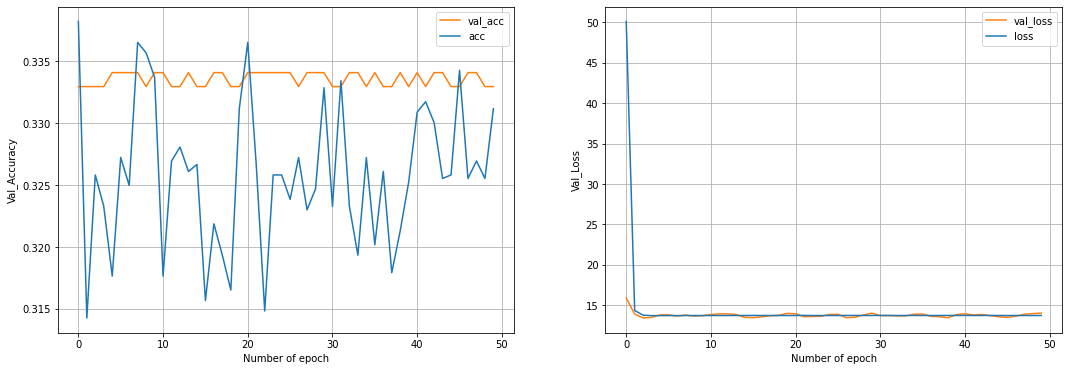

In [ ]:
# evaluate CNN tuned model 1
evaluate_model(history_CNN_tuned_1)

In [ ]:
#  apply regulizer L2 = 0.01 to the three layers with the highest parameters.
def build_tuned_CNN_model_2():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.01)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_2 = build_tuned_CNN_model_2()
CNN_model_2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 71, 71, 128)     

In [ ]:
history_CNN_tuned_2, CNN_tuned_model_2 = train_model(CNN_model_2)

Epoch 1/50
71/71 [==============================] - 74s 1s/step - loss: 3.4551 - accuracy: 0.3461 - val_loss: 2.1697 - val_accuracy: 0.3330
Epoch 2/50
71/71 [==============================] - 72s 1s/step - loss: 1.8790 - accuracy: 0.4228 - val_loss: 1.6720 - val_accuracy: 0.5011
Epoch 3/50
71/71 [==============================] - 72s 1s/step - loss: 1.5586 - accuracy: 0.4870 - val_loss: 1.4714 - val_accuracy: 0.5158
Epoch 4/50
71/71 [==============================] - 71s 1s/step - loss: 1.4195 - accuracy: 0.4983 - val_loss: 1.3518 - val_accuracy: 0.4808
Epoch 5/50
71/71 [==============================] - 75s 1s/step - loss: 1.3051 - accuracy: 0.5020 - val_loss: 1.2562 - val_accuracy: 0.5226
Epoch 6/50
71/71 [==============================] - 72s 1s/step - loss: 1.2355 - accuracy: 0.5101 - val_loss: 1.2040 - val_accuracy: 0.5339
Epoch 7/50
71/71 [==============================] - 73s 1s/step - loss: 1.1882 - accuracy: 0.5099 - val_loss: 1.1584 - val_accuracy: 0.5463
Epoch 8/50
71/71 [==

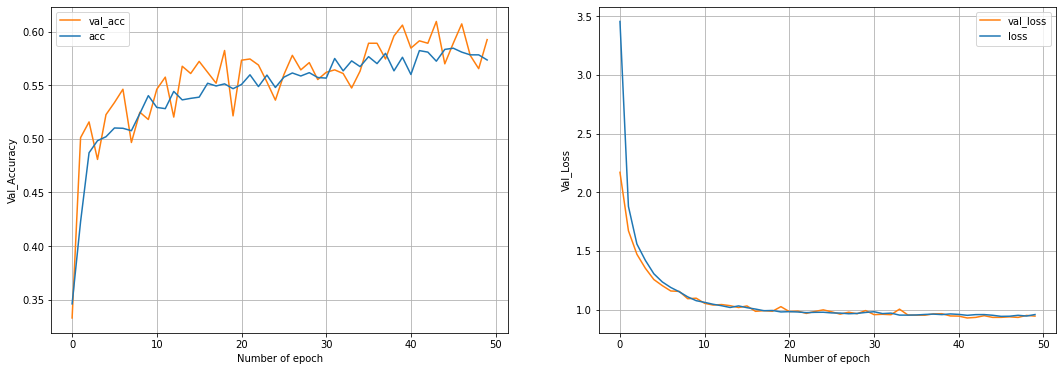

In [ ]:
# evaluate CNN tuned model 2
evaluate_model(history_CNN_tuned_2)

In [ ]:
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
def build_tuned_CNN_model_3():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_3 = build_tuned_CNN_model_3()
CNN_model_3.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 71, 71, 128)     

In [ ]:
history_CNN_tuned_3, CNN_tuned_model_3 = train_model(CNN_model_3)

Epoch 1/50
71/71 [==============================] - 74s 1s/step - loss: 1.7155 - accuracy: 0.3405 - val_loss: 1.3211 - val_accuracy: 0.3758
Epoch 2/50
71/71 [==============================] - 73s 1s/step - loss: 1.2821 - accuracy: 0.3334 - val_loss: 1.2495 - val_accuracy: 0.3330
Epoch 3/50
71/71 [==============================] - 74s 1s/step - loss: 1.2311 - accuracy: 0.3393 - val_loss: 1.2053 - val_accuracy: 0.4368
Epoch 4/50
71/71 [==============================] - 74s 1s/step - loss: 1.1680 - accuracy: 0.4326 - val_loss: 1.1272 - val_accuracy: 0.5214
Epoch 5/50
71/71 [==============================] - 74s 1s/step - loss: 1.0837 - accuracy: 0.5048 - val_loss: 1.0773 - val_accuracy: 0.5237
Epoch 6/50
71/71 [==============================] - 73s 1s/step - loss: 1.0587 - accuracy: 0.5166 - val_loss: 1.0710 - val_accuracy: 0.5361
Epoch 7/50
71/71 [==============================] - 74s 1s/step - loss: 1.0330 - accuracy: 0.5465 - val_loss: 1.0555 - val_accuracy: 0.5530
Epoch 8/50
71/71 [==

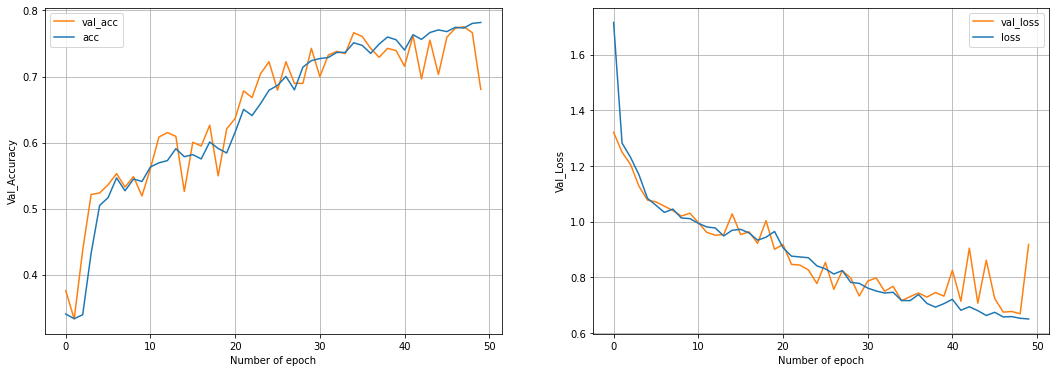

In [ ]:
# evaluate CNN tuned model 3
evaluate_model(history_CNN_tuned_3)

In [ ]:
#  apply regulizer L2 = 0.1 to the three layers with the highest parameters.
def build_tuned_CNN_model_4():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.1)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.1)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.1)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_4 = build_tuned_CNN_model_4()
CNN_model_4.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 71, 71, 128)     

In [ ]:
history_CNN_tuned_4, CNN_tuned_model_4 = train_model(CNN_model_4)

Epoch 1/50
71/71 [==============================] - 76s 1s/step - loss: 7.7323 - accuracy: 0.3481 - val_loss: 2.4036 - val_accuracy: 0.4074
Epoch 2/50
71/71 [==============================] - 74s 1s/step - loss: 1.6960 - accuracy: 0.3630 - val_loss: 1.3226 - val_accuracy: 0.3330
Epoch 3/50
71/71 [==============================] - 75s 1s/step - loss: 1.2204 - accuracy: 0.3315 - val_loss: 1.1578 - val_accuracy: 0.3330
Epoch 4/50
71/71 [==============================] - 72s 1s/step - loss: 1.1346 - accuracy: 0.3309 - val_loss: 1.1185 - val_accuracy: 0.3341
Epoch 5/50
71/71 [==============================] - 73s 1s/step - loss: 1.1116 - accuracy: 0.3334 - val_loss: 1.1061 - val_accuracy: 0.3341
Epoch 6/50
71/71 [==============================] - 73s 1s/step - loss: 1.1035 - accuracy: 0.3309 - val_loss: 1.1015 - val_accuracy: 0.3341
Epoch 7/50
71/71 [==============================] - 73s 1s/step - loss: 1.1007 - accuracy: 0.3207 - val_loss: 1.0998 - val_accuracy: 0.3330
Epoch 8/50
71/71 [==

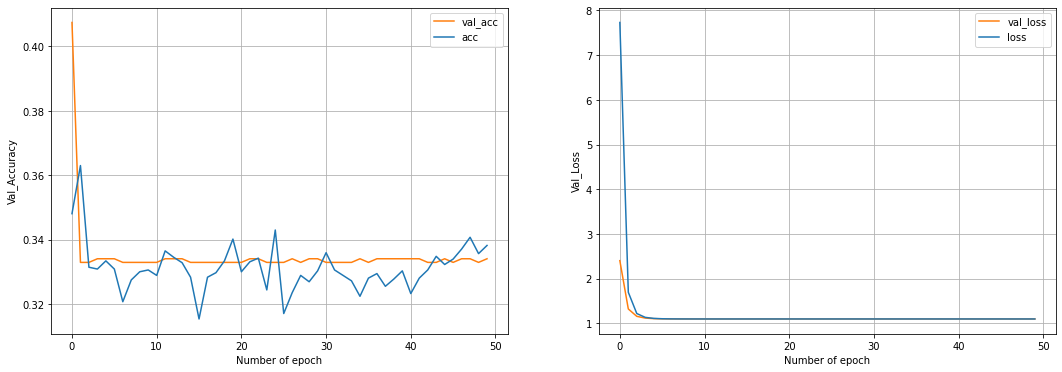

In [ ]:
# evaluate CNN tuned model 4
evaluate_model(history_CNN_tuned_4)

In [ ]:
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
#  apply dropout only on the layer with many parameters.
def build_tuned_CNN_model_5():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_5 = build_tuned_CNN_model_5()
CNN_model_5.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 35, 35, 128)      

In [ ]:
history_CNN_tuned_5, CNN_tuned_model_5 = train_model(CNN_model_5)

Epoch 1/100
71/71 [==============================] - 78s 1s/step - loss: 1.4276 - accuracy: 0.4242 - val_loss: 1.1989 - val_accuracy: 0.5271
Epoch 2/100
71/71 [==============================] - 76s 1s/step - loss: 1.1321 - accuracy: 0.5228 - val_loss: 1.1047 - val_accuracy: 0.5102
Epoch 3/100
71/71 [==============================] - 77s 1s/step - loss: 1.0642 - accuracy: 0.5355 - val_loss: 1.0186 - val_accuracy: 0.5779
Epoch 4/100
71/71 [==============================] - 77s 1s/step - loss: 1.0422 - accuracy: 0.5426 - val_loss: 1.0696 - val_accuracy: 0.5282
Epoch 5/100
71/71 [==============================] - 75s 1s/step - loss: 1.0286 - accuracy: 0.5561 - val_loss: 0.9773 - val_accuracy: 0.6117
Epoch 6/100
71/71 [==============================] - 76s 1s/step - loss: 0.9913 - accuracy: 0.5767 - val_loss: 0.9841 - val_accuracy: 0.5722
Epoch 7/100
71/71 [==============================] - 75s 1s/step - loss: 0.9491 - accuracy: 0.6161 - val_loss: 0.9929 - val_accuracy: 0.5982
Epoch 8/100
7

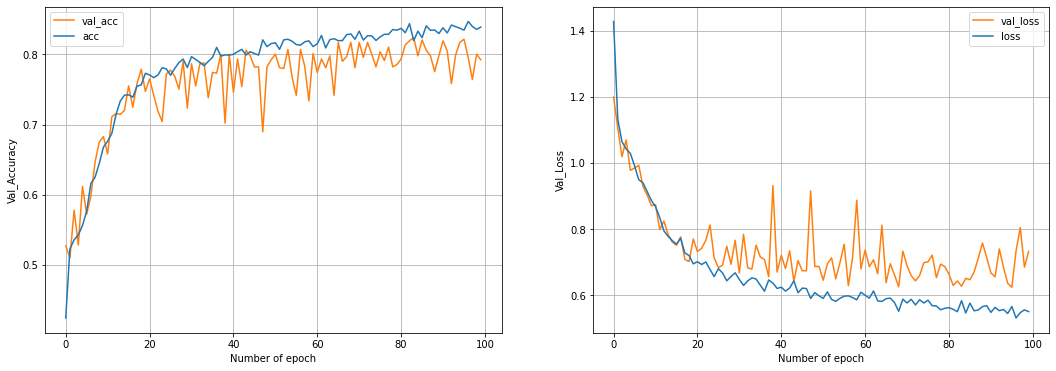

In [ ]:
# evaluate CNN tuned model 5
evaluate_model(history_CNN_tuned_5)

In [ ]:
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
#  apply dropout only on the layer with many parameters.
#  apply adam optimizer with learning rate = 0.0001
def build_tuned_CNN_model_6():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     adam = Adam(learning_rate=0.0001)
     model.compile(optimizer=adam, loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_6 = build_tuned_CNN_model_6()
CNN_model_6.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 35, 35, 128)     

In [ ]:
history_CNN_tuned_6, CNN_tuned_model_6 = train_model(CNN_model_6)

Epoch 1/50
71/71 [==============================] - 76s 1s/step - loss: 1.3056 - accuracy: 0.3960 - val_loss: 1.2364 - val_accuracy: 0.5147
Epoch 2/50
71/71 [==============================] - 75s 1s/step - loss: 1.1709 - accuracy: 0.5180 - val_loss: 1.1408 - val_accuracy: 0.5406
Epoch 3/50
71/71 [==============================] - 75s 1s/step - loss: 1.1089 - accuracy: 0.5465 - val_loss: 1.1057 - val_accuracy: 0.5576
Epoch 4/50
71/71 [==============================] - 75s 1s/step - loss: 1.0751 - accuracy: 0.5682 - val_loss: 1.0785 - val_accuracy: 0.5564
Epoch 5/50
71/71 [==============================] - 75s 1s/step - loss: 1.0542 - accuracy: 0.5634 - val_loss: 1.0576 - val_accuracy: 0.5880
Epoch 6/50
71/71 [==============================] - 75s 1s/step - loss: 1.0349 - accuracy: 0.5778 - val_loss: 1.0268 - val_accuracy: 0.6005
Epoch 7/50
71/71 [==============================] - 75s 1s/step - loss: 1.0028 - accuracy: 0.5879 - val_loss: 1.0114 - val_accuracy: 0.5971
Epoch 8/50
71/71 [==

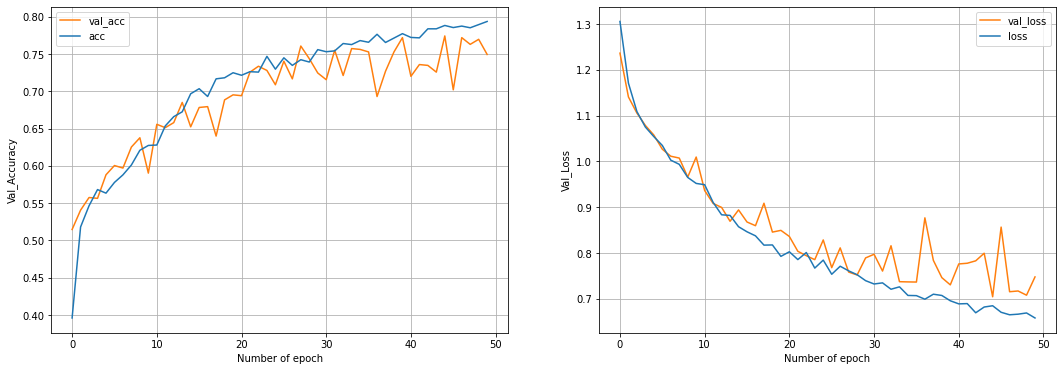

In [ ]:
# evaluate CNN tuned model 6
evaluate_model(history_CNN_tuned_6)

In [ ]:
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
#  apply dropout only on the layer with many parameters.
#  add extra training data
def build_tuned_CNN_model_7():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_7 = build_tuned_CNN_model_7()
CNN_model_7.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 35, 35, 128)     

In [ ]:
# train 5854 images
history_CNN_tuned_7, CNN_tuned_model_7 = train_model(CNN_model_7)

Epoch 1/50
71/71 [==============================] - 192s 2s/step - loss: 1.6106 - accuracy: 0.3592 - val_loss: 1.2891 - val_accuracy: 0.3984
Epoch 2/50
71/71 [==============================] - 126s 2s/step - loss: 1.1745 - accuracy: 0.4857 - val_loss: 1.0978 - val_accuracy: 0.5352
Epoch 3/50
71/71 [==============================] - 126s 2s/step - loss: 1.0053 - accuracy: 0.5999 - val_loss: 1.0506 - val_accuracy: 0.5770
Epoch 4/50
71/71 [==============================] - 126s 2s/step - loss: 0.9628 - accuracy: 0.6247 - val_loss: 1.0256 - val_accuracy: 0.5797
Epoch 5/50
71/71 [==============================] - 126s 2s/step - loss: 0.8886 - accuracy: 0.6686 - val_loss: 0.9670 - val_accuracy: 0.5900
Epoch 6/50
71/71 [==============================] - 127s 2s/step - loss: 0.8297 - accuracy: 0.7028 - val_loss: 0.9546 - val_accuracy: 0.6413
Epoch 7/50
71/71 [==============================] - 127s 2s/step - loss: 0.7740 - accuracy: 0.7298 - val_loss: 0.9140 - val_accuracy: 0.6489
Epoch 8/50
71

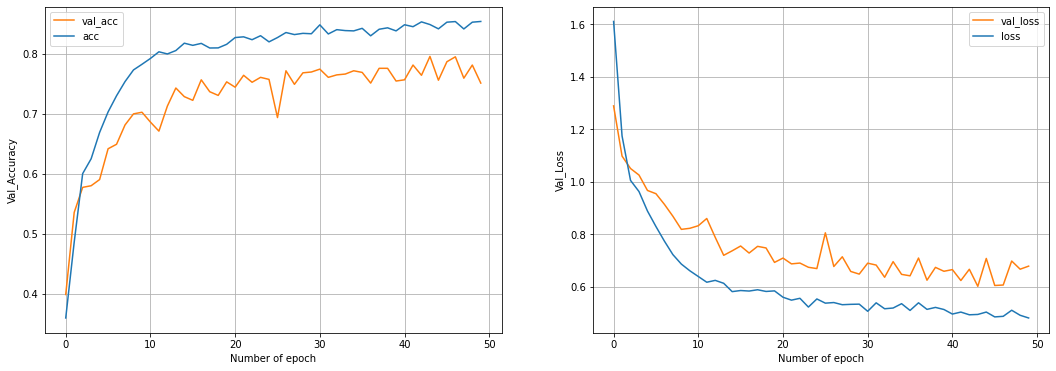

In [ ]:
# evaluate CNN tuned model 7
evaluate_model(history_CNN_tuned_7)

In [ ]:
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
#  apply dropout only on the layer with many parameters.
#  apply adam optimizer with learning rate = 0.00001
def build_tuned_CNN_model_8():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     adam = Adam(learning_rate=0.00001)
     model.compile(optimizer=adam, loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_8 = build_tuned_CNN_model_8()
CNN_model_8.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0

In [ ]:
history_CNN_tuned_8, CNN_tuned_model_8 = train_model(CNN_model_8)

Epoch 1/50
71/71 [==============================] - 1345s 19s/step - loss: 1.3537 - accuracy: 0.3455 - val_loss: 1.3419 - val_accuracy: 0.3894
Epoch 2/50
71/71 [==============================] - 75s 1s/step - loss: 1.3323 - accuracy: 0.3760 - val_loss: 1.3313 - val_accuracy: 0.3804
Epoch 3/50
71/71 [==============================] - 75s 1s/step - loss: 1.3175 - accuracy: 0.4061 - val_loss: 1.3156 - val_accuracy: 0.4233
Epoch 4/50
71/71 [==============================] - 75s 1s/step - loss: 1.2997 - accuracy: 0.4276 - val_loss: 1.3036 - val_accuracy: 0.4357
Epoch 5/50
71/71 [==============================] - 75s 1s/step - loss: 1.2764 - accuracy: 0.4481 - val_loss: 1.3005 - val_accuracy: 0.4074
Epoch 6/50
71/71 [==============================] - 75s 1s/step - loss: 1.2598 - accuracy: 0.4752 - val_loss: 1.2743 - val_accuracy: 0.4357
Epoch 7/50
71/71 [==============================] - 76s 1s/step - loss: 1.2360 - accuracy: 0.4775 - val_loss: 1.2698 - val_accuracy: 0.4424
Epoch 8/50
71/71 

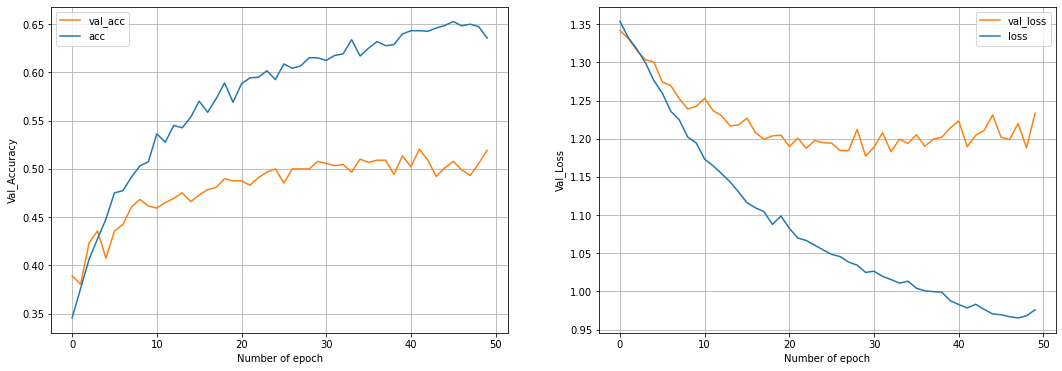

In [ ]:
# evaluate CNN tuned model 8
evaluate_model(history_CNN_tuned_8)

In [ ]:
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
#  apply dropout only on the layer with many parameters.
#  comes after model 7
#  increase batch size to 128
def build_tuned_CNN_model_9():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.4))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.4))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.4))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_9 = build_tuned_CNN_model_9()
CNN_model_9.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 35, 35, 128)     

In [ ]:
# train 5854 images
history_CNN_tuned_9, CNN_tuned_model_9 = train_model(CNN_model_9)

Epoch 1/50
46/46 [==============================] - 122s 3s/step - loss: 1.9003 - accuracy: 0.3304 - val_loss: 1.3899 - val_accuracy: 0.3552
Epoch 2/50
46/46 [==============================] - 121s 3s/step - loss: 1.3055 - accuracy: 0.4149 - val_loss: 1.2361 - val_accuracy: 0.4990
Epoch 3/50
46/46 [==============================] - 120s 3s/step - loss: 1.1355 - accuracy: 0.5357 - val_loss: 1.1639 - val_accuracy: 0.4778
Epoch 4/50
46/46 [==============================] - 119s 3s/step - loss: 1.0633 - accuracy: 0.5721 - val_loss: 1.1333 - val_accuracy: 0.4620
Epoch 5/50
46/46 [==============================] - 120s 3s/step - loss: 1.0261 - accuracy: 0.5883 - val_loss: 1.0484 - val_accuracy: 0.5886
Epoch 6/50
46/46 [==============================] - 119s 3s/step - loss: 0.9733 - accuracy: 0.6285 - val_loss: 1.0052 - val_accuracy: 0.6235
Epoch 7/50
46/46 [==============================] - 119s 3s/step - loss: 0.9299 - accuracy: 0.6548 - val_loss: 0.9866 - val_accuracy: 0.6078
Epoch 8/50
46

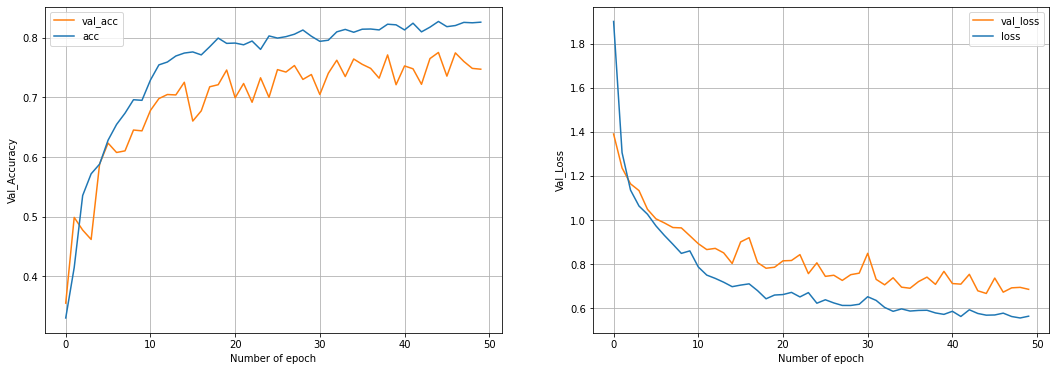

In [ ]:
# evaluate CNN tuned model 9
evaluate_model(history_CNN_tuned_9)

In [ ]:
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
#  apply dropout only on the layer with many parameters.
#  apply sgd optimizer
def build_tuned_CNN_model_10():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='sgd', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_10 = build_tuned_CNN_model_10()
CNN_model_10.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 35, 35, 128)      

In [ ]:
history_CNN_tuned_10, CNN_tuned_model_10 = train_model(CNN_model_10)

Epoch 1/50
71/71 [==============================] - 75s 1s/step - loss: 1.3613 - accuracy: 0.3357 - val_loss: 1.3441 - val_accuracy: 0.4221
Epoch 2/50
71/71 [==============================] - 74s 1s/step - loss: 1.3373 - accuracy: 0.3867 - val_loss: 1.3320 - val_accuracy: 0.4244
Epoch 3/50
71/71 [==============================] - 74s 1s/step - loss: 1.3222 - accuracy: 0.4059 - val_loss: 1.3142 - val_accuracy: 0.4142
Epoch 4/50
71/71 [==============================] - 75s 1s/step - loss: 1.3066 - accuracy: 0.4456 - val_loss: 1.2952 - val_accuracy: 0.4752
Epoch 5/50
71/71 [==============================] - 75s 1s/step - loss: 1.2811 - accuracy: 0.4732 - val_loss: 1.2693 - val_accuracy: 0.5113
Epoch 6/50
71/71 [==============================] - 73s 1s/step - loss: 1.2547 - accuracy: 0.4946 - val_loss: 1.2617 - val_accuracy: 0.5079
Epoch 7/50
71/71 [==============================] - 74s 1s/step - loss: 1.2377 - accuracy: 0.5082 - val_loss: 1.2386 - val_accuracy: 0.5350
Epoch 8/50
71/71 [==

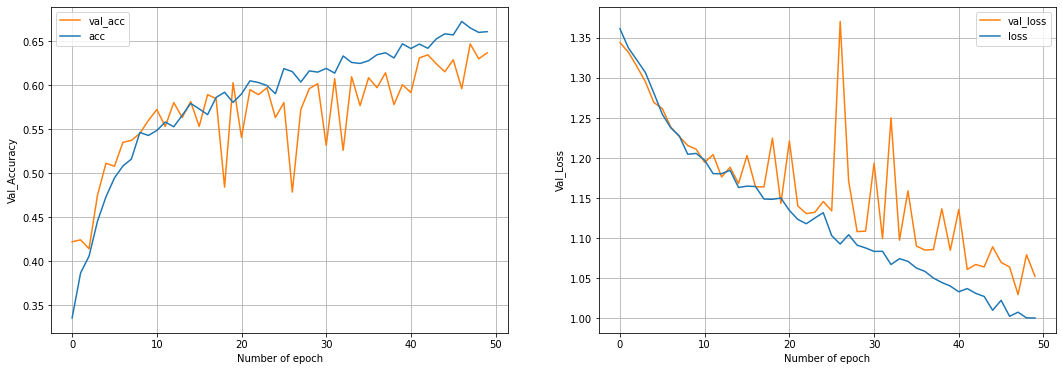

In [ ]:
# evaluate CNN tuned model 10
evaluate_model(history_CNN_tuned_10)

In [ ]:
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
#  apply dropout only on the layer with many parameters.
#  apply sgd optimizer with learning_rate = 0.001, momentum = 0.9
def build_tuned_CNN_model_11():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     sgd = SGD(learning_rate = 0.001, momentum=0.9)
     model.compile(optimizer=sgd, loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_11 = build_tuned_CNN_model_11()
CNN_model_11.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 35, 35, 128)      

In [ ]:
history_CNN_tuned_11, CNN_tuned_model_11 = train_model(CNN_model_11)

Epoch 1/50
71/71 [==============================] - 82s 1s/step - loss: 1.3585 - accuracy: 0.3557 - val_loss: 1.3453 - val_accuracy: 0.3950
Epoch 2/50
71/71 [==============================] - 80s 1s/step - loss: 1.3441 - accuracy: 0.3785 - val_loss: 1.3392 - val_accuracy: 0.3860
Epoch 3/50
71/71 [==============================] - 80s 1s/step - loss: 1.3321 - accuracy: 0.4036 - val_loss: 1.3242 - val_accuracy: 0.4673
Epoch 4/50
71/71 [==============================] - 80s 1s/step - loss: 1.3095 - accuracy: 0.4352 - val_loss: 1.3046 - val_accuracy: 0.4819
Epoch 5/50
71/71 [==============================] - 80s 1s/step - loss: 1.2884 - accuracy: 0.4608 - val_loss: 1.2779 - val_accuracy: 0.5237
Epoch 6/50
71/71 [==============================] - 80s 1s/step - loss: 1.2561 - accuracy: 0.5003 - val_loss: 1.2506 - val_accuracy: 0.5282
Epoch 7/50
71/71 [==============================] - 80s 1s/step - loss: 1.2420 - accuracy: 0.5245 - val_loss: 1.2624 - val_accuracy: 0.4842
Epoch 8/50
71/71 [==

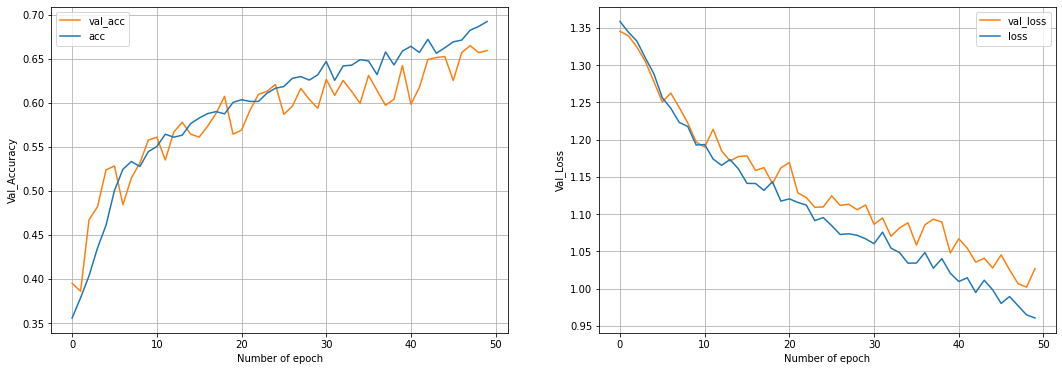

In [ ]:
# evaluate CNN tuned model 11
evaluate_model(history_CNN_tuned_11)

In [ ]:
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
#  apply dropout only on the layer with many parameters.
#  final model comes from model_5
def build_final_CNN_model():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_final = build_final_CNN_model()
CNN_model_final.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 35, 35, 128)     

In [ ]:
history_CNN_final, CNN_final_model = train_model(CNN_model_final)

Epoch 1/50
108/108 [==============================] - 79s 723ms/step - loss: 1.2823 - accuracy: 0.4812 - val_loss: 1.1180 - val_accuracy: 0.5285
Epoch 2/50
108/108 [==============================] - 77s 709ms/step - loss: 1.0688 - accuracy: 0.5475 - val_loss: 1.1218 - val_accuracy: 0.4599
Epoch 3/50
108/108 [==============================] - 77s 711ms/step - loss: 1.0291 - accuracy: 0.5675 - val_loss: 1.0172 - val_accuracy: 0.5796
Epoch 4/50
108/108 [==============================] - 77s 714ms/step - loss: 0.9876 - accuracy: 0.5803 - val_loss: 1.0233 - val_accuracy: 0.5761
Epoch 5/50
108/108 [==============================] - 77s 708ms/step - loss: 0.9650 - accuracy: 0.6020 - val_loss: 0.9785 - val_accuracy: 0.6039
Epoch 6/50
108/108 [==============================] - 76s 703ms/step - loss: 0.9367 - accuracy: 0.6264 - val_loss: 0.9481 - val_accuracy: 0.6434
Epoch 7/50
108/108 [==============================] - 76s 702ms/step - loss: 0.9123 - accuracy: 0.6478 - val_loss: 0.8925 - val_ac

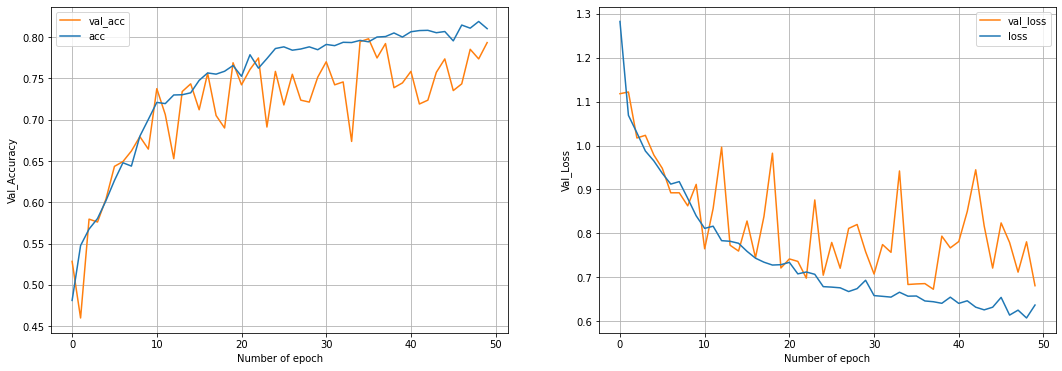

In [ ]:
# evaluate CNN final model
evaluate_model(history_CNN_final)

In [ ]:
save_model(CNN_final_model,'Final_CNN_model')

Model Saved Successfully.


In [ ]:
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
#  apply dropout only on the layer with many parameters.
#  final model comes from model_5
#  training with extra images
def build_final_CNN_model_2():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_final_2 = build_final_CNN_model_2()
CNN_model_final_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 128)      

In [ ]:
history_CNN_final_2, CNN_final_model_2 = train_model(CNN_model_final_2)

Epoch 1/50
177/177 [==============================] - 2106s 12s/step - loss: 1.4142 - accuracy: 0.3518 - val_loss: 1.1988 - val_accuracy: 0.4345
Epoch 2/50
177/177 [==============================] - 112s 630ms/step - loss: 1.1779 - accuracy: 0.3420 - val_loss: 1.1546 - val_accuracy: 0.3425
Epoch 3/50
177/177 [==============================] - 112s 631ms/step - loss: 1.1439 - accuracy: 0.3447 - val_loss: 1.1344 - val_accuracy: 0.3425
Epoch 4/50
177/177 [==============================] - 111s 629ms/step - loss: 1.1124 - accuracy: 0.4240 - val_loss: 1.0447 - val_accuracy: 0.5096
Epoch 5/50
177/177 [==============================] - 111s 628ms/step - loss: 1.0652 - accuracy: 0.4917 - val_loss: 0.9999 - val_accuracy: 0.5506
Epoch 6/50
177/177 [==============================] - 111s 627ms/step - loss: 0.9859 - accuracy: 0.5435 - val_loss: 0.8875 - val_accuracy: 0.6115
Epoch 7/50
177/177 [==============================] - 111s 628ms/step - loss: 0.9592 - accuracy: 0.5647 - val_loss: 0.8433 - 

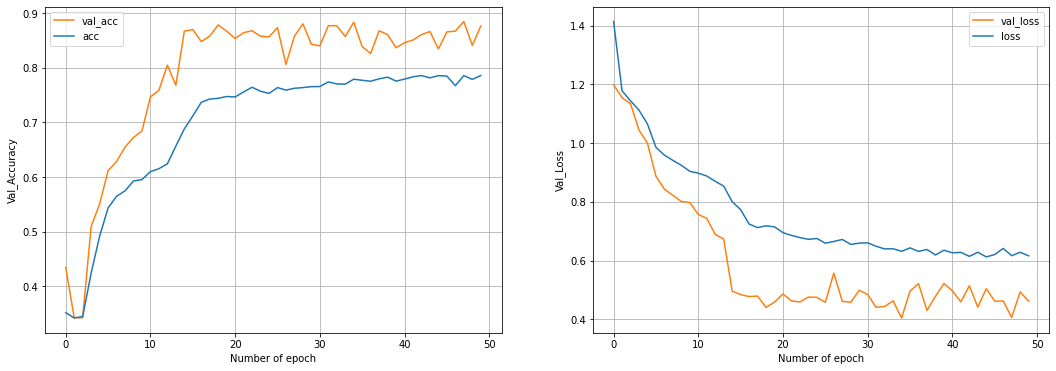

In [ ]:
# evaluate CNN final model 2
evaluate_model(history_CNN_final_2)

In [ ]:
save_model(CNN_final_model_2,'Final_CNN_model_2')

Model Saved Successfully.


Finding the best performance CNN model

In [ ]:
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
#  apply dropout only on the layer with many parameters.
#  final model comes from model_5
#  training with extra images
def build_final_CNN_model_3():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_final_3 = build_final_CNN_model_3()
CNN_model_final_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0

In [ ]:
history_CNN_final_3, CNN_final_model_3 = train_model(CNN_model_final_3)

Epoch 1/100
177/177 [==============================] - 2254s 13s/step - loss: 1.3180 - accuracy: 0.4228 - val_loss: 1.1084 - val_accuracy: 0.4904

Epoch 00001: val_loss improved from inf to 1.10843, saving model to /content/drive/My Drive/app/model.h5
Epoch 2/100
177/177 [==============================] - 123s 694ms/step - loss: 1.0393 - accuracy: 0.5466 - val_loss: 0.8891 - val_accuracy: 0.6752

Epoch 00002: val_loss improved from 1.10843 to 0.88910, saving model to /content/drive/My Drive/app/model.h5
Epoch 3/100
177/177 [==============================] - 122s 690ms/step - loss: 0.9672 - accuracy: 0.5859 - val_loss: 0.8790 - val_accuracy: 0.7240

Epoch 00003: val_loss improved from 0.88910 to 0.87902, saving model to /content/drive/My Drive/app/model.h5
Epoch 4/100
177/177 [==============================] - 124s 700ms/step - loss: 0.8957 - accuracy: 0.6477 - val_loss: 0.7493 - val_accuracy: 0.7481

Epoch 00004: val_loss improved from 0.87902 to 0.74928, saving model to /content/drive

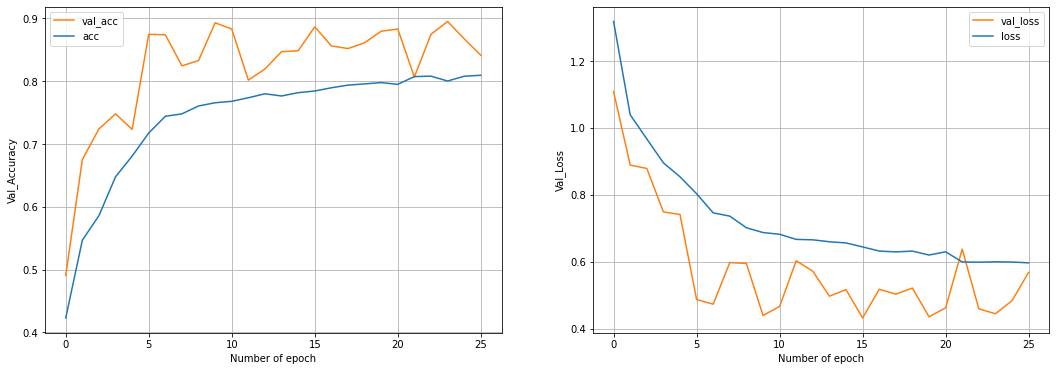

In [ ]:
# evaluate CNN final model 3
evaluate_model(history_CNN_final_3)

Transfer Learning

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(300, 300, 3),
    include_top=False,
    weights='imagenet')

# freeze the convolutional base
base_model.trainable = False

# wrap the model in a sequential model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.AveragePooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(3, activation='softmax'),
])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
average_pooling2d_6 (Average (None, 5, 5, 1280)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 96003     
Total params: 2,353,987
Trainable params: 96,003
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

r = model.fit(
    train,
    validation_data=test,
    epochs=15,
)

Epoch 1/15
182/182 [==============================] - 1916s 11s/step - loss: 0.6053 - accuracy: 0.8640 - val_loss: 0.3455 - val_accuracy: 0.9339
Epoch 2/15
182/182 [==============================] - 129s 706ms/step - loss: 0.5020 - accuracy: 0.9103 - val_loss: 0.3586 - val_accuracy: 0.9381
Epoch 3/15
182/182 [==============================] - 128s 701ms/step - loss: 0.4368 - accuracy: 0.9239 - val_loss: 0.4137 - val_accuracy: 0.9353
Epoch 4/15
182/182 [==============================] - 127s 697ms/step - loss: 0.3639 - accuracy: 0.9367 - val_loss: 0.5349 - val_accuracy: 0.9387
Epoch 5/15
182/182 [==============================] - 128s 702ms/step - loss: 0.4021 - accuracy: 0.9362 - val_loss: 0.3444 - val_accuracy: 0.9532
Epoch 6/15
182/182 [==============================] - 129s 711ms/step - loss: 0.3501 - accuracy: 0.9462 - val_loss: 0.5345 - val_accuracy: 0.9339
Epoch 7/15
182/182 [==============================] - 126s 692ms/step - loss: 0.3883 - accuracy: 0.9421 - val_loss: 0.5133 - 

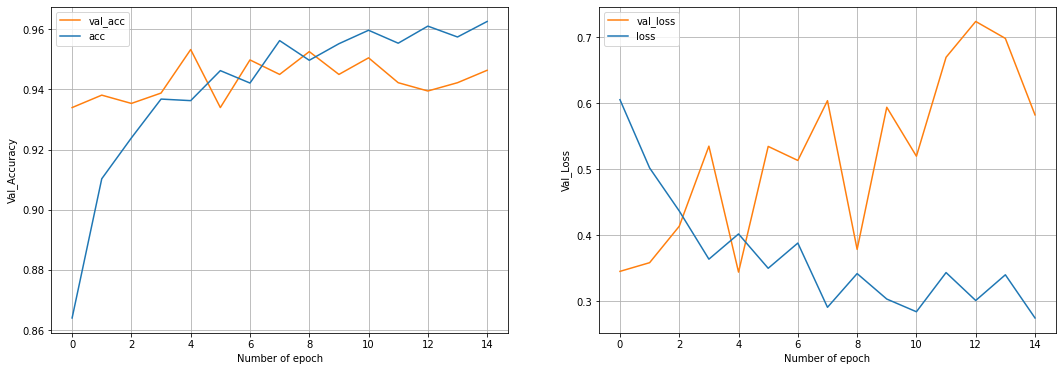

In [ ]:
evaluate_model(r)

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

r = model.fit(
    train,
    validation_data=test,
    initial_epoch=15,
    epochs=30,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 16/30
182/182 [==============================] - 133s 699ms/step - loss: 1.2850 - accuracy: 0.8823 - val_loss: 0.5697 - val_accuracy: 0.9498
Epoch 17/30
182/182 [==============================] - 127s 698ms/step - loss: 0.9367 - accuracy: 0.9091 - val_loss: 0.5653 - val_accuracy: 0.9560
Epoch 18/30
182/182 [==============================] - 127s 697ms/step - loss: 0.7339 - accuracy: 0.9249 - val_loss: 0.6084 - val_accuracy: 0.9566
Epoch 19/30
182/182 [==============================] - 127s 697ms/step - loss: 0.6863 - accuracy: 0.9366 - val_loss: 0.6536 - val_accuracy: 0.9484
Epoch 20/30
182/182 [==============================] - 126s 694ms/step - loss: 0.5473 - accuracy: 0.9431 - val_loss: 0.6163 - val_accuracy: 0.9511
Epoch 21/30
182/182 [==============================] - 130s 716ms/step - loss: 0.4755 - accuracy: 0.9474 - val_loss: 0.5337 - val_accuracy: 0.9560
Epoch 22/30
182/182 [==============================] - 126s 694ms/step - loss: 0.4314 - accuracy: 0.9483 - val_loss: 0

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=3e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

r = model.fit(
    train,
    validation_data=test,
    initial_epoch=30,
    epochs=40,
)

Epoch 31/40
182/182 [==============================] - 137s 714ms/step - loss: 0.4304 - accuracy: 0.9510 - val_loss: 0.5421 - val_accuracy: 0.9546
Epoch 32/40
182/182 [==============================] - 128s 704ms/step - loss: 0.4631 - accuracy: 0.9532 - val_loss: 0.5267 - val_accuracy: 0.9539
Epoch 33/40
182/182 [==============================] - 128s 705ms/step - loss: 0.4073 - accuracy: 0.9527 - val_loss: 0.5186 - val_accuracy: 0.9566
Epoch 34/40
182/182 [==============================] - 128s 703ms/step - loss: 0.4034 - accuracy: 0.9574 - val_loss: 0.5573 - val_accuracy: 0.9546
Epoch 35/40
182/182 [==============================] - 128s 706ms/step - loss: 0.3288 - accuracy: 0.9617 - val_loss: 0.5308 - val_accuracy: 0.9539
Epoch 36/40
182/182 [==============================] - 129s 709ms/step - loss: 0.3673 - accuracy: 0.9615 - val_loss: 0.5265 - val_accuracy: 0.9511
Epoch 37/40
182/182 [==============================] - 129s 709ms/step - loss: 0.3459 - accuracy: 0.9634 - val_loss: 0

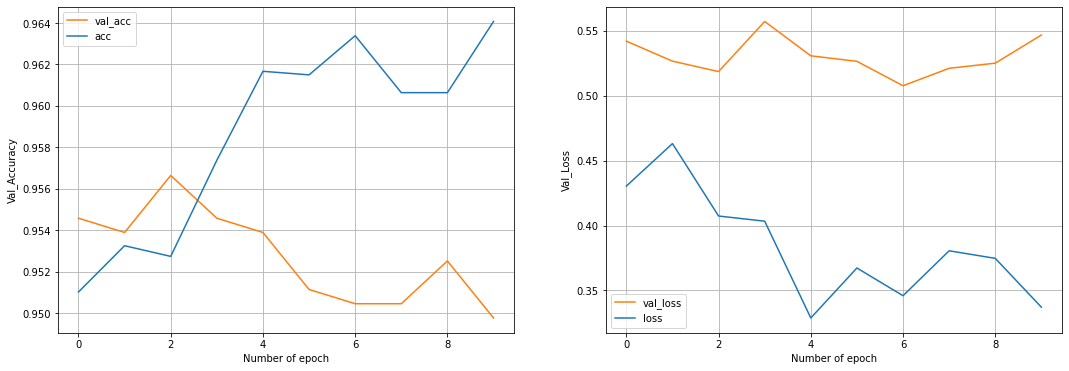

In [ ]:
evaluate_model(r)

Test

In [ ]:
# Import modules for test
from tensorflow.keras.models import load_model

In [ ]:
MLP = load_model(model_save_dir + 'MLP_model.h5')
CNN_final = load_model(model_save_dir + 'model.h5')

In [ ]:
print("Loss and Accuracy of MLP model:")
loss, accuracy = MLP.evaluate(testdata)

Loss and Accuracy of MLP model
24/24 [==============================] - 2s 95ms/step - loss: 1.1756 - accuracy: 0.2366


In [ ]:
print("Loss and Accuracy of final CNN model:")
loss, accuracy = CNN_final.evaluate(testdata)

Loss and Accuracy of CNN model with extra images, with early stop training:
24/24 [==============================] - 2s 96ms/step - loss: 0.5456 - accuracy: 0.8280
